In [142]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


In [143]:
base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'
# base_path = 'C:/Users/nicho/Desktop/gnss_spoof_detector/spoof_detector/data'

In [144]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [145]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [146]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 1),
    (ds3_dict, 1),
    (ds4_dict, 1),
    (ds7_dict, 1),
    (ds8_dict, 1)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
print(big_df.shape)
print(big_df.columns)
print(big_df['spoofed'].value_counts(normalize=True))

big_df

(189272, 12)
Index(['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs',
       'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'pseudorange_m', 'rx_time', 'spoofed'],
      dtype='object')
spoofed
1    0.863181
0    0.136819
Name: proportion, dtype: float64


,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1


In [147]:
big_df.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)
big_df
print(big_df.shape)
print(big_df.columns)
print(big_df.isna().sum())


(189272, 7)
Index(['prn', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'rx_time', 'spoofed'],
      dtype='object')
prn                   0
prompt_i              0
prompt_q              0
cn0_db_hz             0
carrier_doppler_hz    0
rx_time               0
spoofed               0
dtype: int64


In [148]:
# Sort by PRN and rx_time (in case it's not already)
big_df = big_df.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
window_size = 500

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'{col}_roll_mean'] = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df[f'{col}_roll_std']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df[f'{col}_roll_min']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df[f'{col}_roll_max']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'cn0_db_hz_roll_mean', 'cn0_db_hz_roll_std', 'cn0_db_hz_roll_min', 'cn0_db_hz_roll_max', 'carrier_doppler_hz_roll_mean', 'carrier_doppler_hz_roll_std', 'carrier_doppler_hz_roll_min', 'carrier_doppler_hz_roll_max']].head()



,prn,cn0_db_hz,carrier_doppler_hz,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max
6474,3,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0
6475,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'delta_{col}'] = big_df.groupby('prn')[col].diff().fillna(0)

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'delta_cn0_db_hz', 'delta_carrier_doppler_hz']].head()



,prn,cn0_db_hz,carrier_doppler_hz,delta_cn0_db_hz,delta_carrier_doppler_hz
6474,3,0.0,0.0,0.0,0.0
6475,3,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0


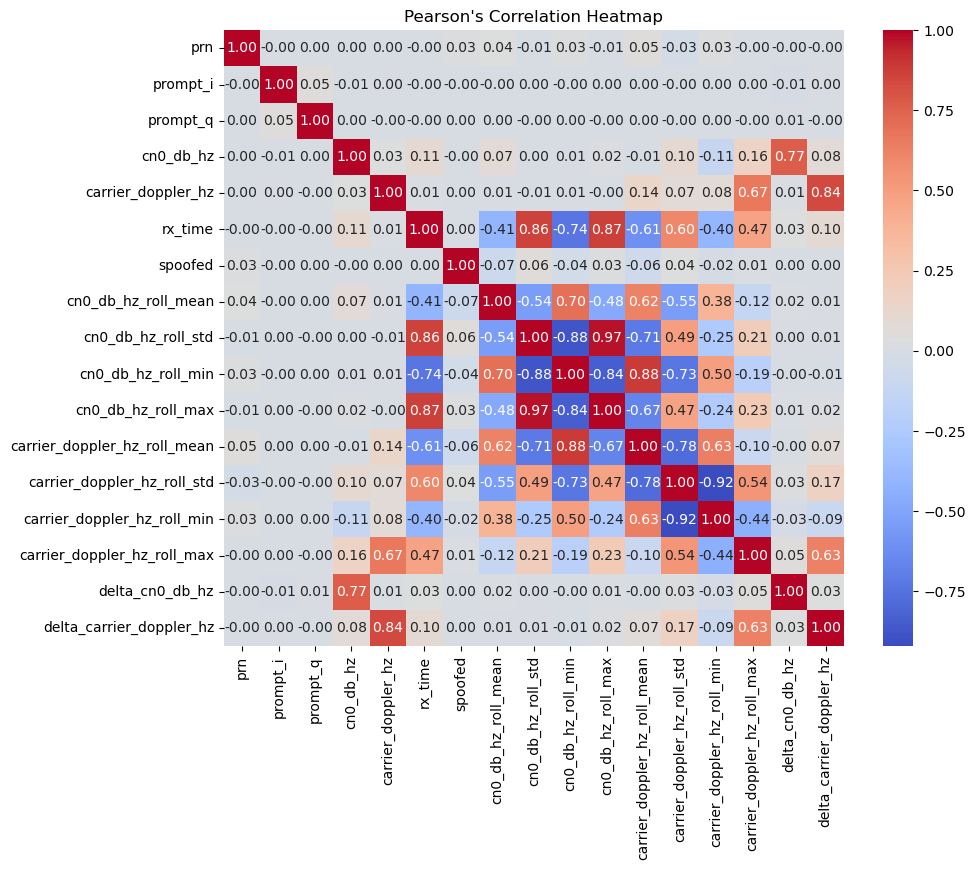

In [150]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [151]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [152]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 1),
    (ds3_dict, 1),
    (ds4_dict, 1),
    (ds7_dict, 1),
    (ds8_dict, 1)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,1


In [153]:
big_df_no_diff.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)

In [154]:
# Calculate magnitude and phase
big_df['prompt_magnitude'] = np.sqrt(big_df['prompt_i']**2 + big_df['prompt_q']**2)
big_df['prompt_phase'] = np.arctan2(big_df['prompt_q'], big_df['prompt_i'])

# Calculate deltas (first-order difference)
big_df['delta_prompt_magnitude'] = big_df['prompt_magnitude'].diff().fillna(0)
big_df['delta_prompt_phase'] = big_df['prompt_phase'].diff().fillna(0)


In [155]:
# Calculate magnitude and phase
big_df_no_diff['prompt_magnitude'] = np.sqrt(big_df_no_diff['prompt_i']**2 + big_df_no_diff['prompt_q']**2)
big_df_no_diff['prompt_phase'] = np.arctan2(big_df_no_diff['prompt_q'], big_df_no_diff['prompt_i'])

# Calculate deltas (first-order difference)
big_df_no_diff['delta_prompt_magnitude'] = big_df_no_diff['prompt_magnitude'].diff().fillna(0)
big_df_no_diff['delta_prompt_phase'] = big_df_no_diff['prompt_phase'].diff().fillna(0)

# window_size = 200

big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df['prompt_magnitude_roll_std'] = big_df['prompt_magnitude'].rolling(window_size).std().fillna(0)

big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df_no_diff['prompt_magnitude_roll_std'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).std().fillna(0)

/var/folders/02/v2ckl3ls7fb8jf20p533z8840000gn/T/ipykernel_26711/4218134096.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
/var/folders/02/v2ckl3ls7fb8jf20p533z8840000gn/T/ipykernel_26711/4218134096.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')


In [156]:
# Sort by PRN and rx_time (in case it's not already)
big_df_no_diff = big_df_no_diff.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
# window_size = 200

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'{col}_roll_mean'] = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df_no_diff[f'{col}_roll_std']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df_no_diff[f'{col}_roll_min']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df_no_diff[f'{col}_roll_max']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

In [157]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'delta_{col}'] = big_df_no_diff.groupby('prn')[col].diff().fillna(0)


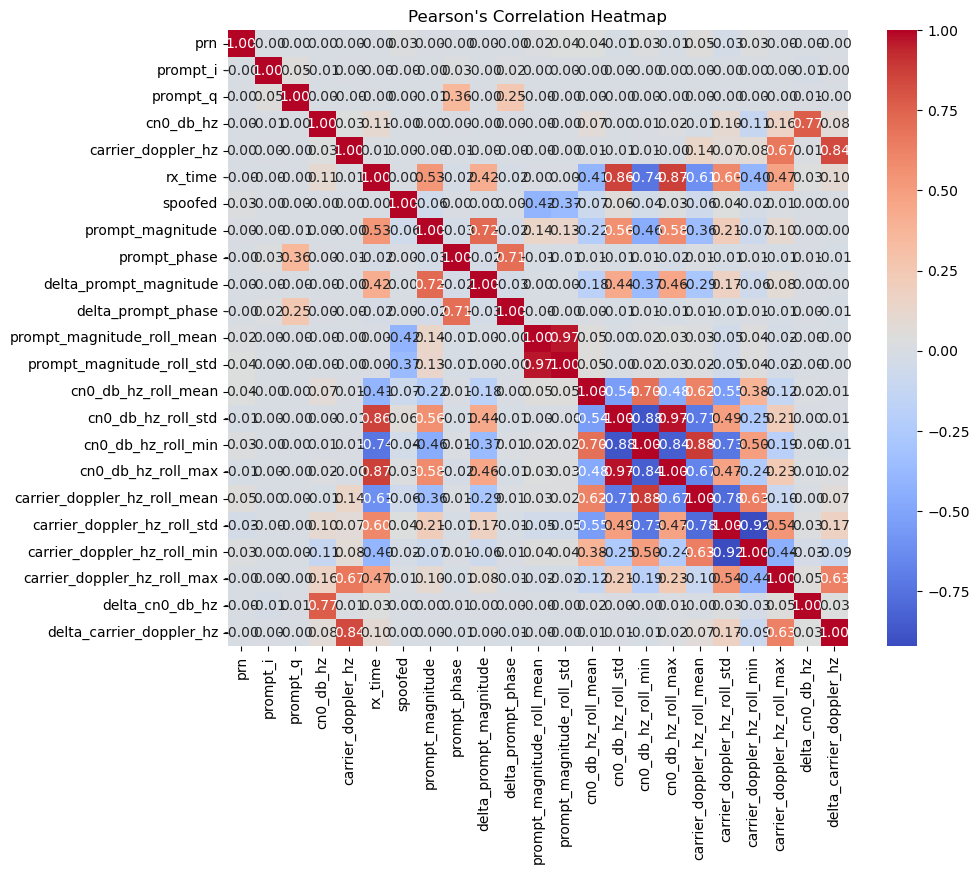

In [158]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [159]:
big_df_no_diff.drop(columns=['prn'], inplace=True)
big_df.drop(columns=['prn'], inplace=True)

In [160]:
#scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(big_df.drop('spoofed', axis=1))

scaled_df = pd.DataFrame(scaled_df, columns=big_df.drop('spoofed', axis=1).columns)
scaled_df['spoofed'] = big_df['spoofed'].values


In [161]:
#scale data
scaler = StandardScaler()
scaled_df_no_diff = scaler.fit_transform(big_df_no_diff.drop('spoofed', axis=1))

scaled_df_no_diff = pd.DataFrame(scaled_df_no_diff, columns=big_df_no_diff.drop('spoofed', axis=1).columns)
scaled_df_no_diff['spoofed'] = big_df_no_diff['spoofed'].values

In [162]:
scaled_df.dropna(inplace=True)
scaled_df_no_diff.dropna(inplace=True)

In [163]:
# SVM with diff
X = scaled_df.drop(columns=['spoofed'])
y = scaled_df['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_no_diff = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_diff = scaled_df_no_diff['spoofed']

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff = train_test_split(X_no_diff, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff, X_val_no_diff, y_train_no_diff, y_val_no_diff = train_test_split(X_train_no_diff, y_train_no_diff, test_size=0.2, shuffle=True)    

In [164]:
X_train

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,...,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,prompt_magnitude_roll_std
8685,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.179078,-0.359992,0.308914,-0.350516,0.247638,...,0.075617,-0.074797,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.360063,-0.382126
186057,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.179078,-0.359992,0.308914,-0.350516,0.247638,...,0.075617,-0.074797,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,3.037064,3.363446
156706,-0.010577,0.524619,-1.643902,0.114507,2.356523,0.021726,1.970321,-1.626561,1.633394,-1.528367,...,-0.186896,0.449203,-2.793613,0.293588,-0.207572,3.186874,-1.616275e-02,2.785347,0.813881,1.499503
147630,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.179078,-0.359992,0.308914,-0.350516,0.247638,...,0.075617,-0.074797,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.360063,-0.382126
106710,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.179078,-0.359992,0.308914,-0.350516,0.247638,...,0.075617,-0.074797,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.360063,-0.382126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124972,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.179078,-0.359992,0.308914,-0.350516,0.247638,...,0.075617,-0.074797,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.360063,-0.382126
69481,1.081177,-1.338438,0.987677,-0.155155,2.356523,-10.229101,3.899274,-11.967063,3.147772,-13.712767,...,-12.783166,1.076924,3.409636,-0.278201,0.884380,-0.032379,4.096846e-02,-2.892698,2.557925,2.630395
86312,0.073784,-0.173517,0.067730,-0.282374,2.356523,1.000363,2.569468,-1.362594,2.212545,-2.181002,...,-0.334509,0.639362,2.584223,-0.312446,-0.147969,-0.066502,6.521293e-02,-2.161464,1.808656,1.462782
77911,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.179078,-0.359992,0.308914,-0.350516,0.247638,...,0.075617,-0.074797,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014,-0.360063,-0.382126


In [165]:
X_train_no_diff

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,...,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz
162701,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,1.349069,...,0.179078,-0.359992,0.308914,-0.350516,0.247638,-0.167019,0.075617,-0.074797,-0.000618,-0.001424
173206,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-1.862385,3.057627e+00,-0.316914,...,0.179078,-0.359992,0.308914,-0.350516,0.247638,-0.167019,0.075617,-0.074797,-0.000618,-0.001424
108110,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.843949,...,0.179078,-0.359992,0.308914,-0.350516,0.247638,-0.167019,0.075617,-0.074797,-0.000618,-0.001424
188172,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.494029,...,0.179078,-0.359992,0.308914,-0.350516,0.247638,-0.167019,0.075617,-0.074797,-0.000618,-0.001424
68340,-4.477932,0.839397,0.441239,-0.153696,2.356523,4.363790,4.332859,3.165683,3.059810e+00,0.518491,...,0.448761,1.713989,-1.624490,2.520598,0.152094,0.485100,-0.107313,0.291587,0.618212,-0.273444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127990,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.292890,...,0.179078,-0.359992,0.308914,-0.350516,0.247638,-0.167019,0.075617,-0.074797,-0.000618,-0.001424
168527,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.585819,...,0.179078,-0.359992,0.308914,-0.350516,0.247638,-0.167019,0.075617,-0.074797,-0.000618,-0.001424
127201,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.661869,...,0.179078,-0.359992,0.308914,-0.350516,0.247638,-0.167019,0.075617,-0.074797,-0.000618,-0.001424
82168,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.517988,...,0.179078,-0.359992,0.308914,-0.350516,0.247638,-0.167019,0.075617,-0.074797,-0.000618,-0.001424


In [166]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

spoofed
1    0.863144
0    0.136856
Name: proportion, dtype: float64
spoofed
1    0.865559
0    0.134441
Name: proportion, dtype: float64


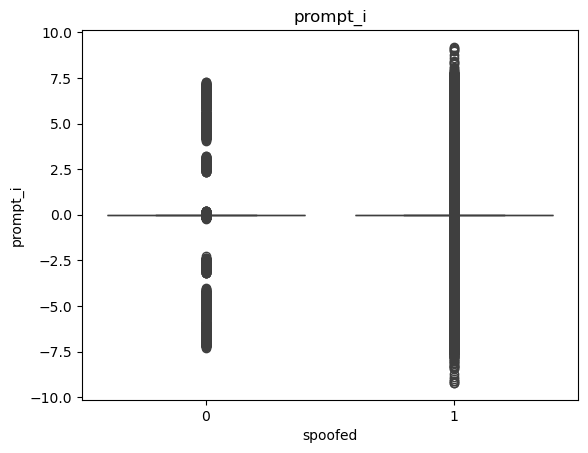

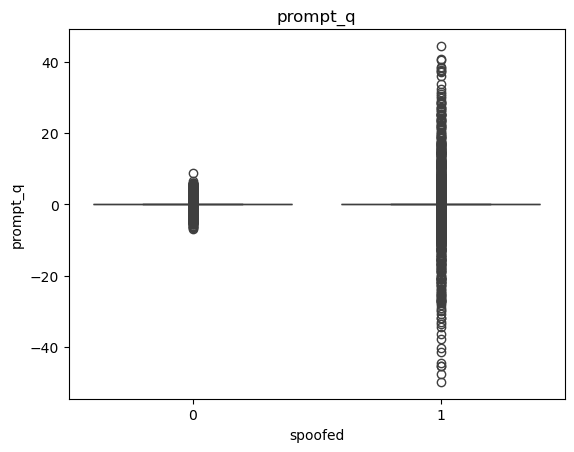

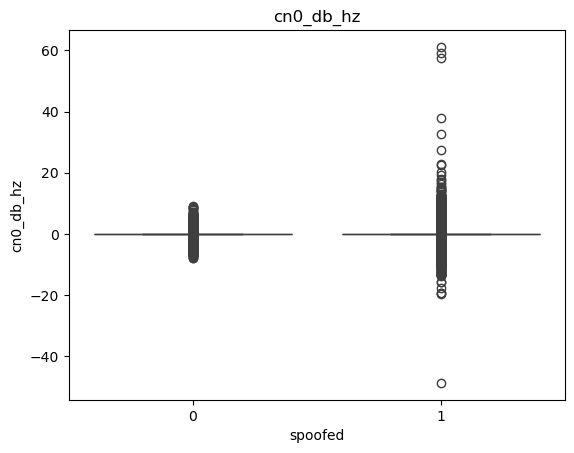

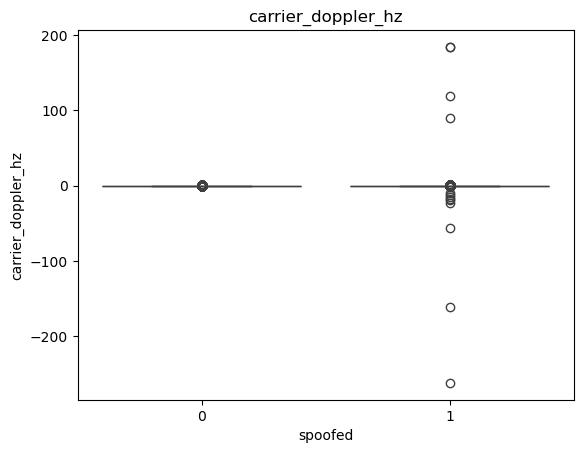

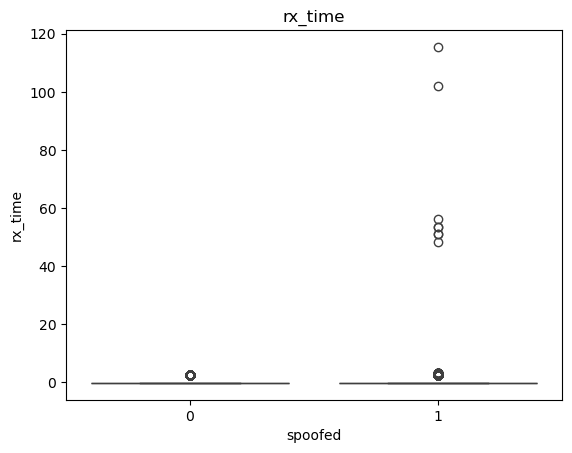

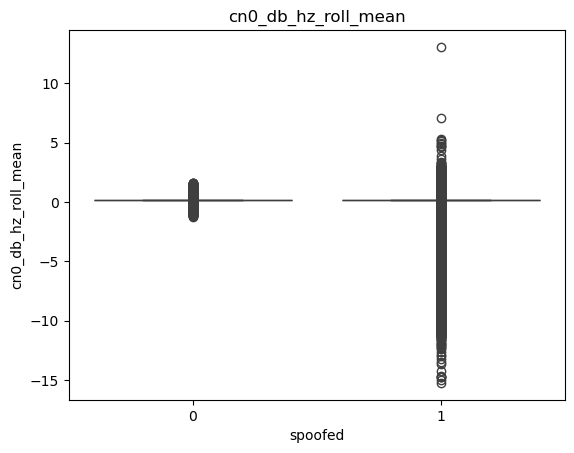

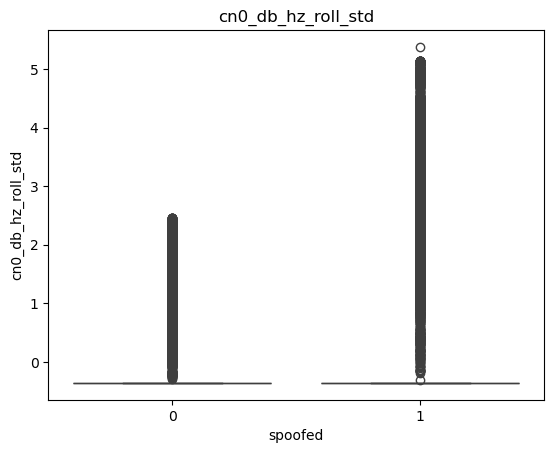

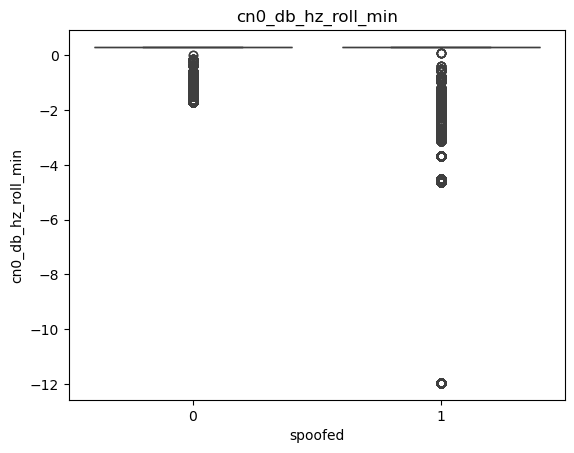

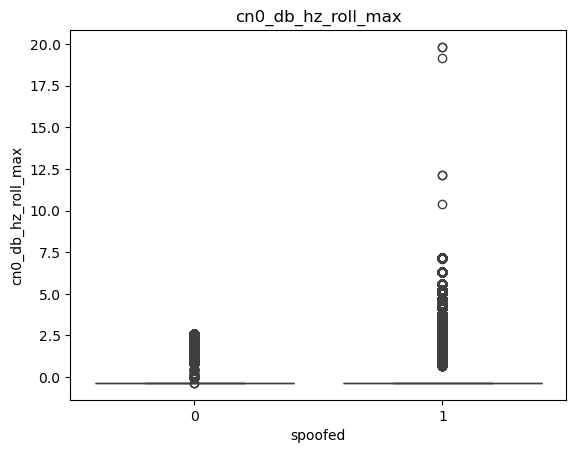

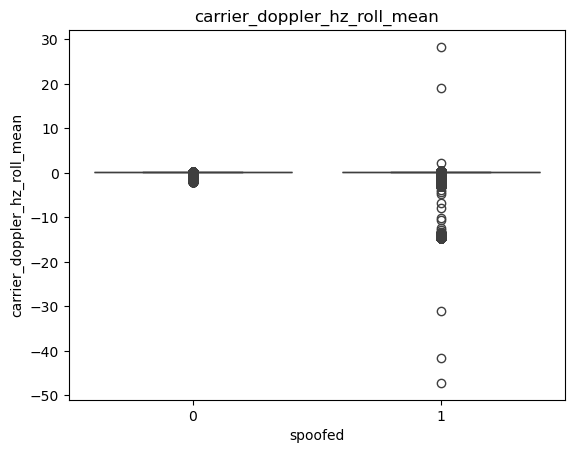

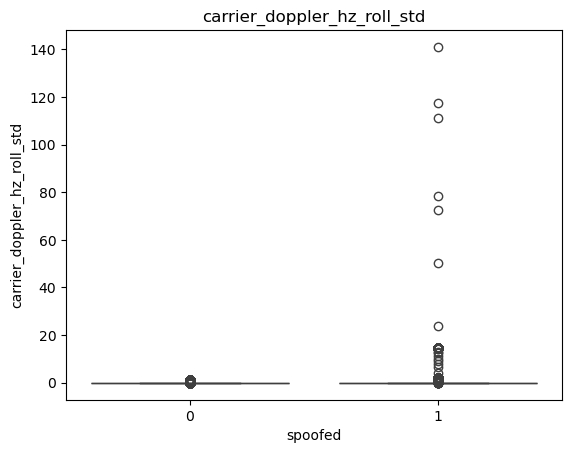

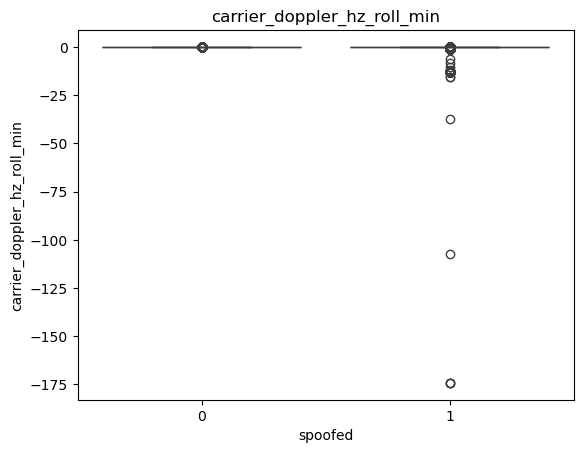

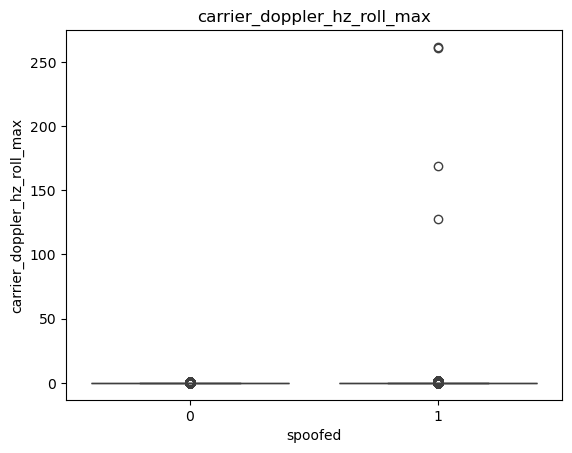

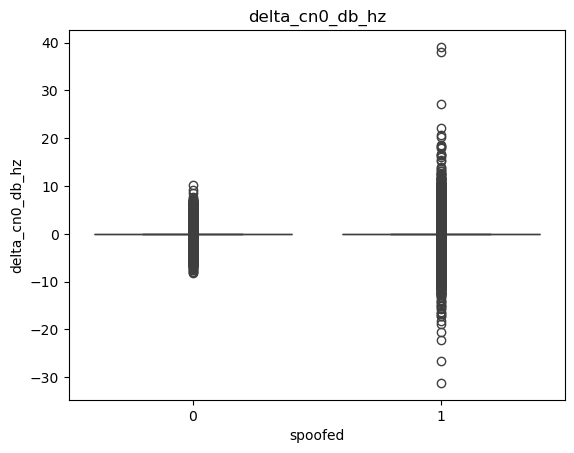

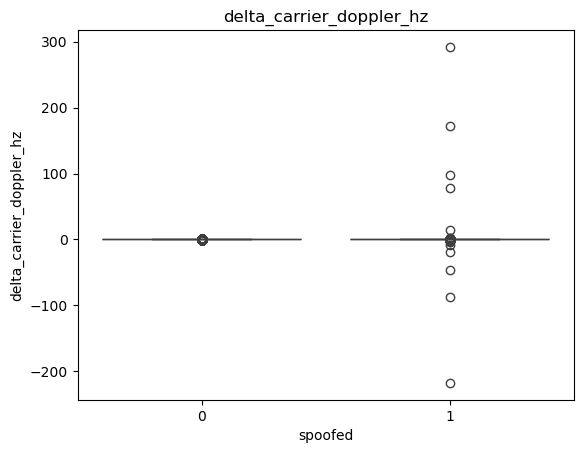

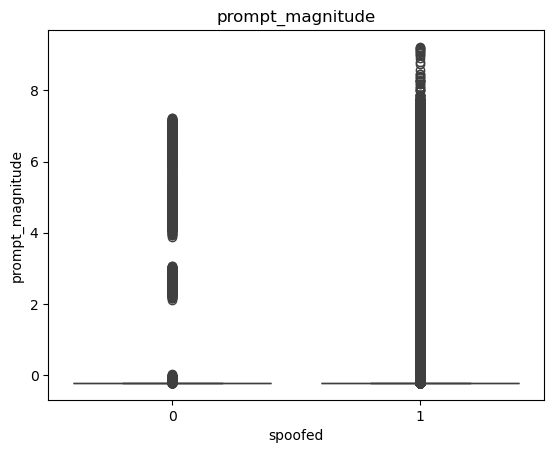

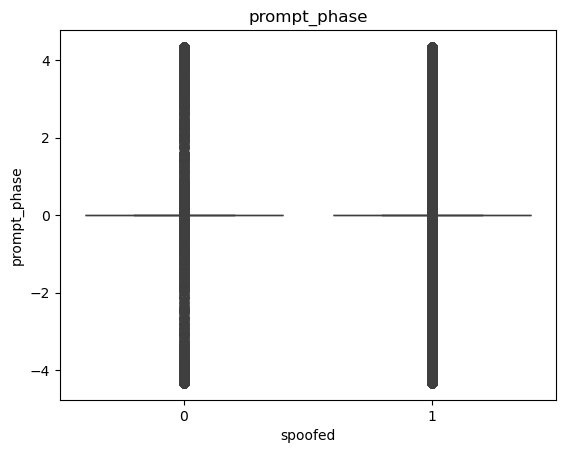

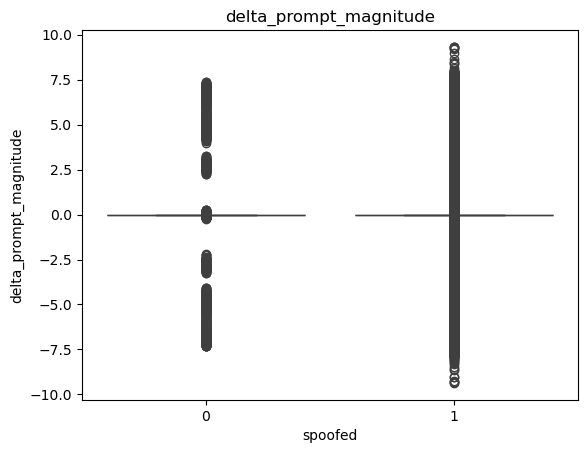

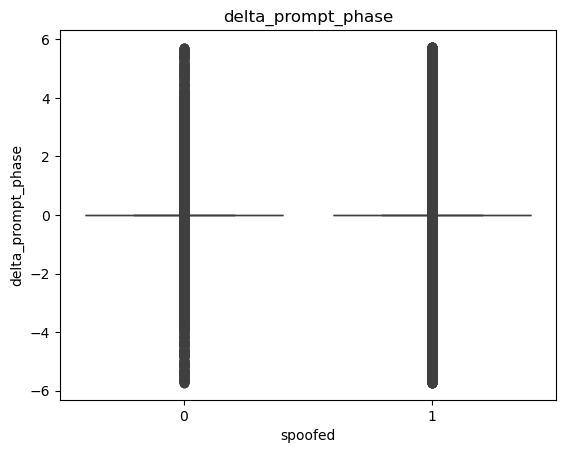

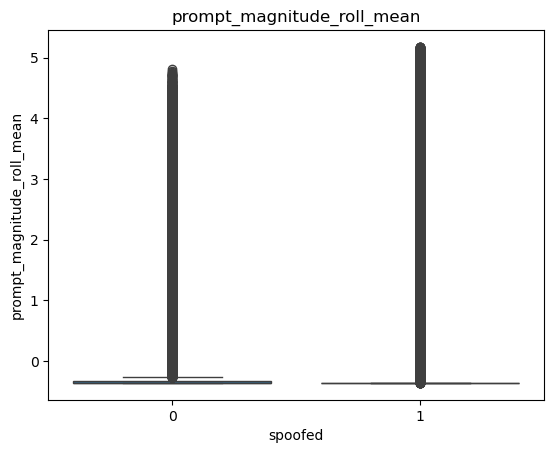

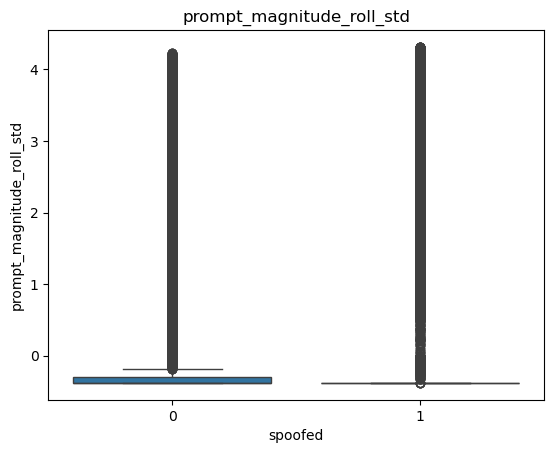

In [167]:
for col in X.columns:
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
    plt.show()

In [168]:
scaled_df.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
prompt_magnitude_roll_std       0.091221
cn0_db_hz_roll_mean             0.074564
carrier_doppler_hz_roll_mean    0.058994
cn0_db_hz_roll_std              0.056104
prompt_magnitude                0.055874
cn0_db_hz_roll_min              0.043338
carrier_doppler_hz_roll_std     0.038156
prompt_magnitude_roll_mean      0.037121
cn0_db_hz_roll_max              0.031407
carrier_doppler_hz_roll_min     0.020753
carrier_doppler_hz_roll_max     0.012445
prompt_phase                    0.003596
cn0_db_hz                       0.000780
delta_carrier_doppler_hz        0.000571
delta_prompt_magnitude          0.000241
delta_cn0_db_hz                 0.000219
prompt_i                        0.000184
prompt_q                        0.000095
carrier_doppler_hz              0.000057
delta_prompt_phase              0.000050
rx_time                         0.000014
Name: spoofed, dtype: float64

In [169]:
scaled_df_no_diff.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
prompt_magnitude_roll_mean      0.417101
prompt_magnitude_roll_std       0.368550
cn0_db_hz_roll_mean             0.074564
carrier_doppler_hz_roll_mean    0.058994
cn0_db_hz_roll_std              0.056104
prompt_magnitude                0.055874
cn0_db_hz_roll_min              0.043338
carrier_doppler_hz_roll_std     0.038156
cn0_db_hz_roll_max              0.031407
carrier_doppler_hz_roll_min     0.020753
carrier_doppler_hz_roll_max     0.012445
prompt_phase                    0.003596
cn0_db_hz                       0.000780
delta_carrier_doppler_hz        0.000571
delta_cn0_db_hz                 0.000219
prompt_i                        0.000184
prompt_q                        0.000095
carrier_doppler_hz              0.000057
rx_time                         0.000014
delta_prompt_phase              0.000013
delta_prompt_magnitude          0.000007
Name: spoofed, dtype: float64

In [ ]:
svm = SVC(kernel='rbf', C=1, class_weight='balanced')
svm.fit(X_train, y_train)

SVC(C=1.5, class_weight='balanced')

In [ ]:
svm_no_diff = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_no_diff.fit(X_train_no_diff, y_train_no_diff)

it updates


In [231]:
#PCA for SVM
pca = PCA(n_components=.95)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, shuffle=True)
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_pca, y_train_pca, test_size=0.2, shuffle=True)

X_no_diff_pca = pca.fit_transform(X_no_diff)
X_train_no_diff_pca, X_test_no_diff_pca, y_train_no_diff_pca, y_test_no_diff_pca = train_test_split(X_no_diff_pca, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff_pca, X_val_no_diff_pca, y_train_no_diff_pca, y_val_no_diff_pca = train_test_split(X_train_no_diff_pca, y_train_no_diff_pca, test_size=0.2, shuffle=True)

In [ ]:
svm_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_pca.fit(X_train_pca, y_train_pca)

SVC(C=1.5, class_weight='balanced')

In [ ]:
svm_no_diff_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_no_diff_pca.fit(X_train_no_diff_pca, y_train_no_diff_pca)

SVC(C=1.5, class_weight='balanced')

In [234]:
y_pred = svm.predict(X_test)

In [235]:
y_pred_no_diff = svm_no_diff.predict(X_test_no_diff)

In [236]:
y_pred_pca = svm_pca.predict(X_test_pca)

In [237]:
y_pred_no_diff_pca = svm_no_diff_pca.predict(X_test_no_diff_pca)

              precision    recall  f1-score   support

           0       0.82      0.24      0.38      5089
           1       0.89      0.99      0.94     32764

    accuracy                           0.89     37853
   macro avg       0.86      0.62      0.66     37853
weighted avg       0.88      0.89      0.86     37853



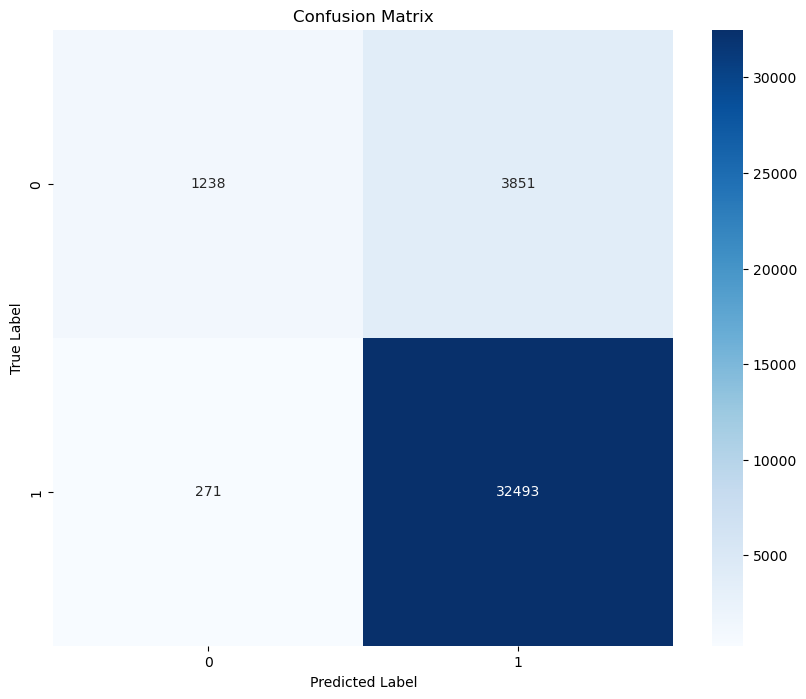

In [238]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.28      0.92      0.43      5213
           1       0.98      0.62      0.76     32640

    accuracy                           0.66     37853
   macro avg       0.63      0.77      0.60     37853
weighted avg       0.88      0.66      0.72     37853



Text(95.72222222222221, 0.5, 'True Label')

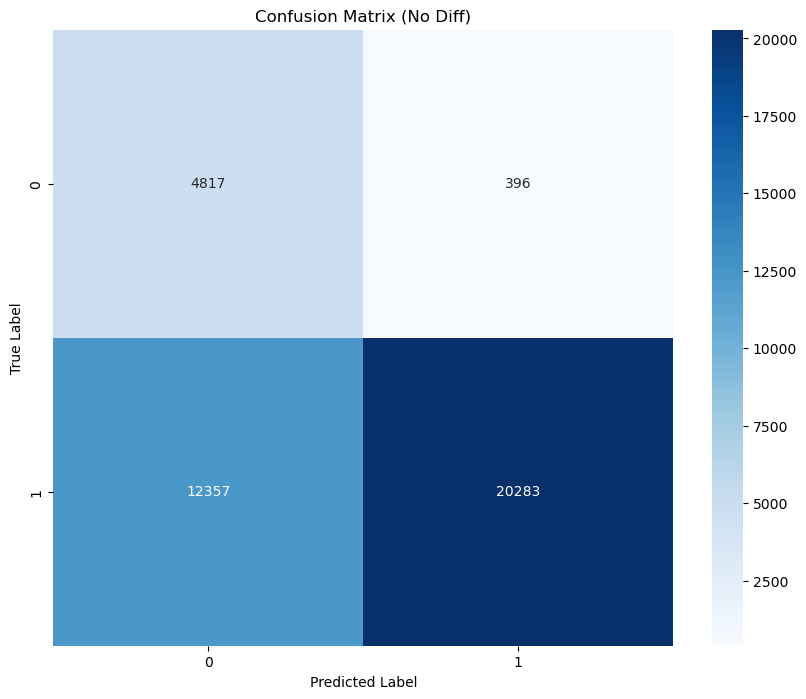

In [239]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

              precision    recall  f1-score   support

           0       0.77      0.24      0.37      5176
           1       0.89      0.99      0.94     32677

    accuracy                           0.89     37853
   macro avg       0.83      0.62      0.65     37853
weighted avg       0.87      0.89      0.86     37853



Text(95.72222222222221, 0.5, 'True Label')

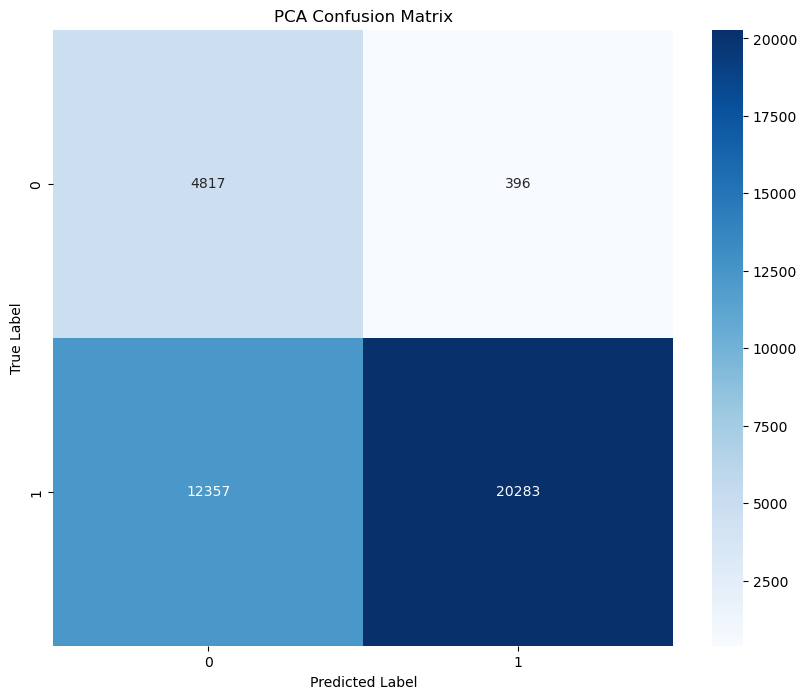

In [240]:
print(classification_report(y_test_pca, y_pred_pca))
cm_pca = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

              precision    recall  f1-score   support

           0       0.27      0.91      0.41      5139
           1       0.98      0.61      0.75     32714

    accuracy                           0.65     37853
   macro avg       0.62      0.76      0.58     37853
weighted avg       0.88      0.65      0.71     37853



Text(95.72222222222221, 0.5, 'True Label')

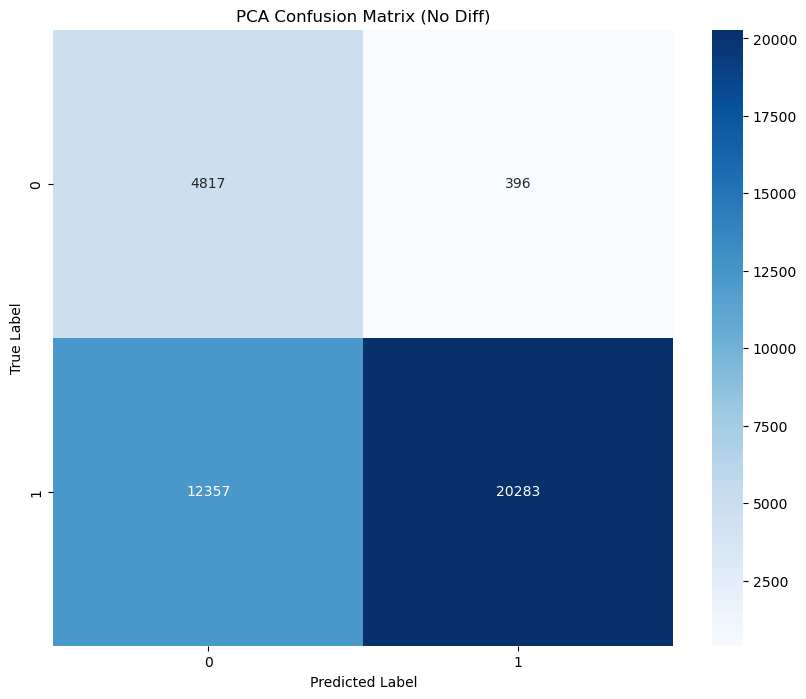

In [241]:
print(classification_report(y_test_no_diff_pca, y_pred_no_diff_pca))
cm_pca_no_diff = confusion_matrix(y_test_no_diff_pca, y_pred_no_diff_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [242]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced', max_depth=25)
rf_model.fit(X_train, y_train)

rf_model_no_diff = RandomForestClassifier(n_estimators=1000, class_weight='balanced', max_depth=25)
rf_model_no_diff.fit(X_train_no_diff, y_train_no_diff)

print("Random Forest")

importances = rf_model.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

print("\nRandom Forest No Diff")

importances = rf_model_no_diff.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

Random Forest
prompt_i: 0.0015
prompt_q: 0.0010
cn0_db_hz: 0.0004
carrier_doppler_hz: 0.0007
rx_time: 0.0102
cn0_db_hz_roll_mean: 0.0298
cn0_db_hz_roll_std: 0.1058
cn0_db_hz_roll_min: 0.0848
cn0_db_hz_roll_max: 0.0191
carrier_doppler_hz_roll_mean: 0.0642
carrier_doppler_hz_roll_std: 0.1219
carrier_doppler_hz_roll_min: 0.0751
carrier_doppler_hz_roll_max: 0.0586
delta_cn0_db_hz: 0.0003
delta_carrier_doppler_hz: 0.0004
prompt_magnitude: 0.0221
prompt_phase: 0.0003
delta_prompt_magnitude: 0.0017
delta_prompt_phase: 0.0002
prompt_magnitude_roll_mean: 0.1891
prompt_magnitude_roll_std: 0.2127

Random Forest No Diff
prompt_i: 0.0003
prompt_q: 0.0003
cn0_db_hz: 0.0001
carrier_doppler_hz: 0.0002
rx_time: 0.0022
cn0_db_hz_roll_mean: 0.0055
cn0_db_hz_roll_std: 0.0001
cn0_db_hz_roll_min: 0.0323
cn0_db_hz_roll_max: 0.0168
carrier_doppler_hz_roll_mean: 0.4289
carrier_doppler_hz_roll_std: 0.4056
carrier_doppler_hz_roll_min: 0.0063
carrier_doppler_hz_roll_max: 0.0218
delta_cn0_db_hz: 0.0174
delta_carri

In [243]:
y_pred = rf_model.predict(X_test)
y_pred_no_diff = rf_model_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.96      0.26      0.41      5089
           1       0.90      1.00      0.94     32764

    accuracy                           0.90     37853
   macro avg       0.93      0.63      0.68     37853
weighted avg       0.90      0.90      0.87     37853



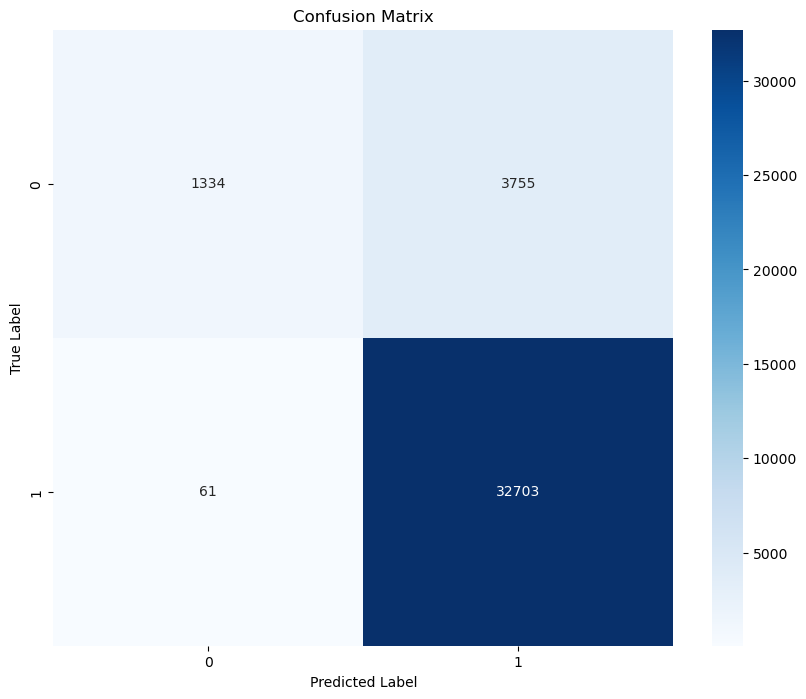

In [244]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.26      0.41      5089
           1       0.90      1.00      0.94     32764

    accuracy                           0.90     37853
   macro avg       0.93      0.63      0.68     37853
weighted avg       0.90      0.90      0.87     37853



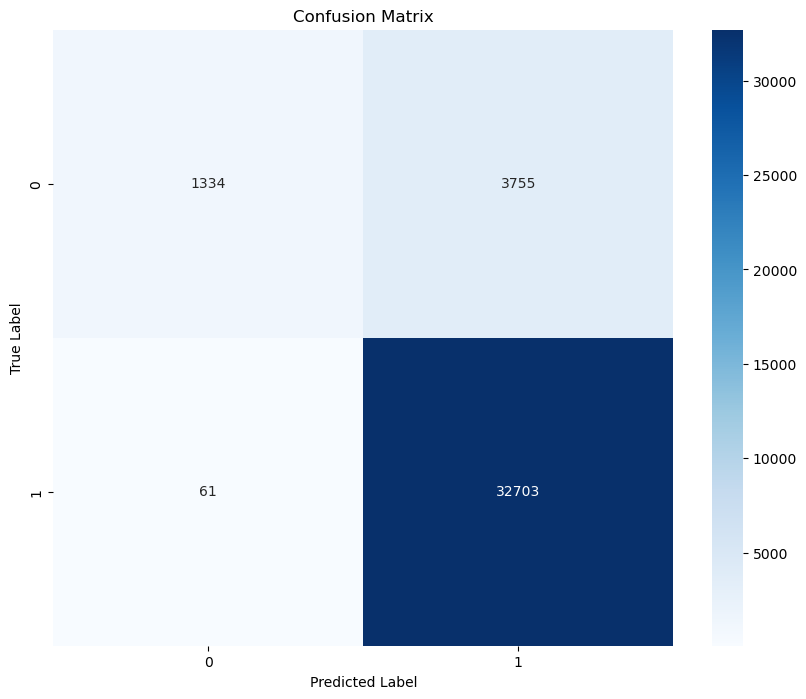

In [245]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

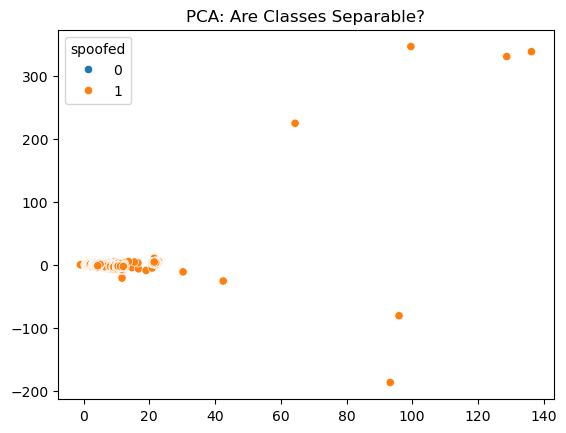

In [246]:



sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA: Are Classes Separable?")
plt.show()
